In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression as linreg
from sklearn.model_selection import cross_validate, KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import factor_analyzer as fa
import pingouin as pg
import scipy.stats as stats
import statsmodels.api as sm
import copy
import itertools

%matplotlib inline
plt.style.use('fivethirtyeight')

tss_df = pd.read_csv("data/combined_data.csv")
items_descr = pd.read_csv("data/description_items.csv")

tss_df.drop(columns="Unnamed: 0", inplace=True)

items_descr.set_index("Unnamed: 0", drop=True, inplace=True)
items_descr.index.set_names("item_label", inplace=True)
items_descr = pd.Series(items_descr.iloc[:, 0], name="item description")

tss_df.head(3)

,response_id,story_id,prompt_label,preset_label,sample,tss_coh_1,tss_coh_2,tss_coh_3,tss_coh_4,tss_coh_5,...,start,end,duration_in_sec,recorded,tss_order,qual_check_1,qual_check_1_order,qual_check_2,pass_qual_1,pass_qual_2
0,R_3LZPTbqxmeWvp7w,GEN_HF_6,High Fantasy,Genesis,Community,2.0,4.0,4.0,4.0,4.0,...,2022-02-17 07:41:22,2022-02-17 07:58:46,1044,2022-02-17 07:58:47,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN
1,R_3CCMkj9T7UgOtgP,ALL_HR_3,Historical Romance,All-Nighter,Community,2.0,4.0,2.0,1.0,2.0,...,2022-02-17 07:52:11,2022-02-17 08:01:19,548,2022-02-17 08:01:20,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN
2,R_3PBKFhmDXlAQNO6,ALL_HOR_2,Horror,All-Nighter,Community,5.0,5.0,1.0,1.0,3.0,...,2022-02-17 07:55:22,2022-02-17 08:03:16,473,2022-02-17 08:03:16,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN


In [62]:
item_labels_li = [
    'tss_coh_1', 'tss_coh_2', 'tss_coh_3', 'tss_coh_4',
    'tss_coh_5', 'tss_coh_6', 'tss_coh_7', 'tss_coh_8', 'tss_coh_9',
    'tss_coh_10', 'tss_coh_11', 'tss_coh_12', 'tss_conch_1', 'tss_conch_2',
    'tss_conch_3', 'tss_conch_4', 'tss_conch_5', 'tss_conch_6',
    'tss_conch_7', 'tss_conch_8', 'tss_cre_1', 'tss_cre_2', 'tss_cre_3',
    'tss_cre_4', 'tss_cre_5', 'tss_cre_6', 'tss_cre_7', 'tss_cre_8',
    'tss_cre_9', 'tss_cre_10', 'tss_cre_11', 'tss_cre_12', 'tss_qua_1',
    'tss_qua_2', 'tss_qua_3', 'tss_qua_4', 'tss_qua_5', 'tss_qua_6',
    'tss_qua_7', 'tss_qua_8', 'tss_rep_1', 'tss_rep_2', 'tss_rep_3',
    'tss_rep_4', 'tss_rep_5', 'tss_rep_6', 'tss_rep_7', 'tss_rep_8',
    'tss_rep_9', 'tss_rep_10', 'tss_rep_11', 'tss_rep_12', 'tss_sty_1',
    'tss_sty_2', 'tss_sty_3', 'tss_sty_4', 'tss_sty_5', 'tss_sty_6',
    'tss_sty_7', 'tss_sty_8', 'tss_sty_9', 'tss_sty_10', 'tss_sty_11',
    'tss_sty_12', 'tss_pac_1', 'tss_pac_2', 'tss_pac_3', 'tss_pac_4',
    'tss_pac_5', 'tss_pac_6', 'tss_pac_7', 'tss_pac_8', 'tss_pac_9'
]

In [63]:
# Check missing data patterns
missing = tss_df[item_labels_li].isna()
print("Top 5 cols with missing data per col:")
print(missing.sum().sort_values(ascending=False).head(5))
print("\nTop 5 missing data per row:")
print(missing.sum(axis=1).sort_values(ascending=False).head(5))

# in this case it is straightforward - just drop the 2 rows with missing data
tss_df.dropna(subset=item_labels_li, inplace=True)

# if missing data should be more common with small amounts of missing data per case, might need different approach obv

Top 5 cols with missing data per col:
tss_coh_1     2
tss_rep_9     2
tss_cre_8     2
tss_cre_10    2
tss_qua_2     2
dtype: int64

Top 5 missing data per row:
117    72
77     35
0       0
124     0
116     0
dtype: int64


In [64]:
# check if items are appropriate for EFA
# correlations mostly |.3|-|.8|
items_corr = tss_df[item_labels_li].corr()

extreme_corrs_count_dict = {}
high_corr_li = []

# print out extreme corrs
total_report = ""
for index, row in items_corr.iterrows():
    variable1 = index
    corrs = row
    i = 0
    count = 0
    for variable2, corr in corrs.iteritems():
        if (variable1 != variable2) and ((abs(corr) < 0.3) or (abs(corr) > 0.8)):
            count += 1
            if abs(corr) > 0.8:
                high_corr_li.append((variable1, variable2, corr))
        i += 1
    extreme_corrs_count_dict[variable1] = count

extreme_corrs_count = pd.Series(extreme_corrs_count_dict)
print("Descriptives for extreme correlation count:")
print(extreme_corrs_count.describe())

# uhmm that are more extreme correlations as I would like
# but maybe subscales are fairly orthogonal?

Descriptives for extreme correlation count:
count    73.000000
mean     50.301370
std      10.310034
min      27.000000
25%      42.000000
50%      52.000000
75%      58.000000
max      70.000000
dtype: float64


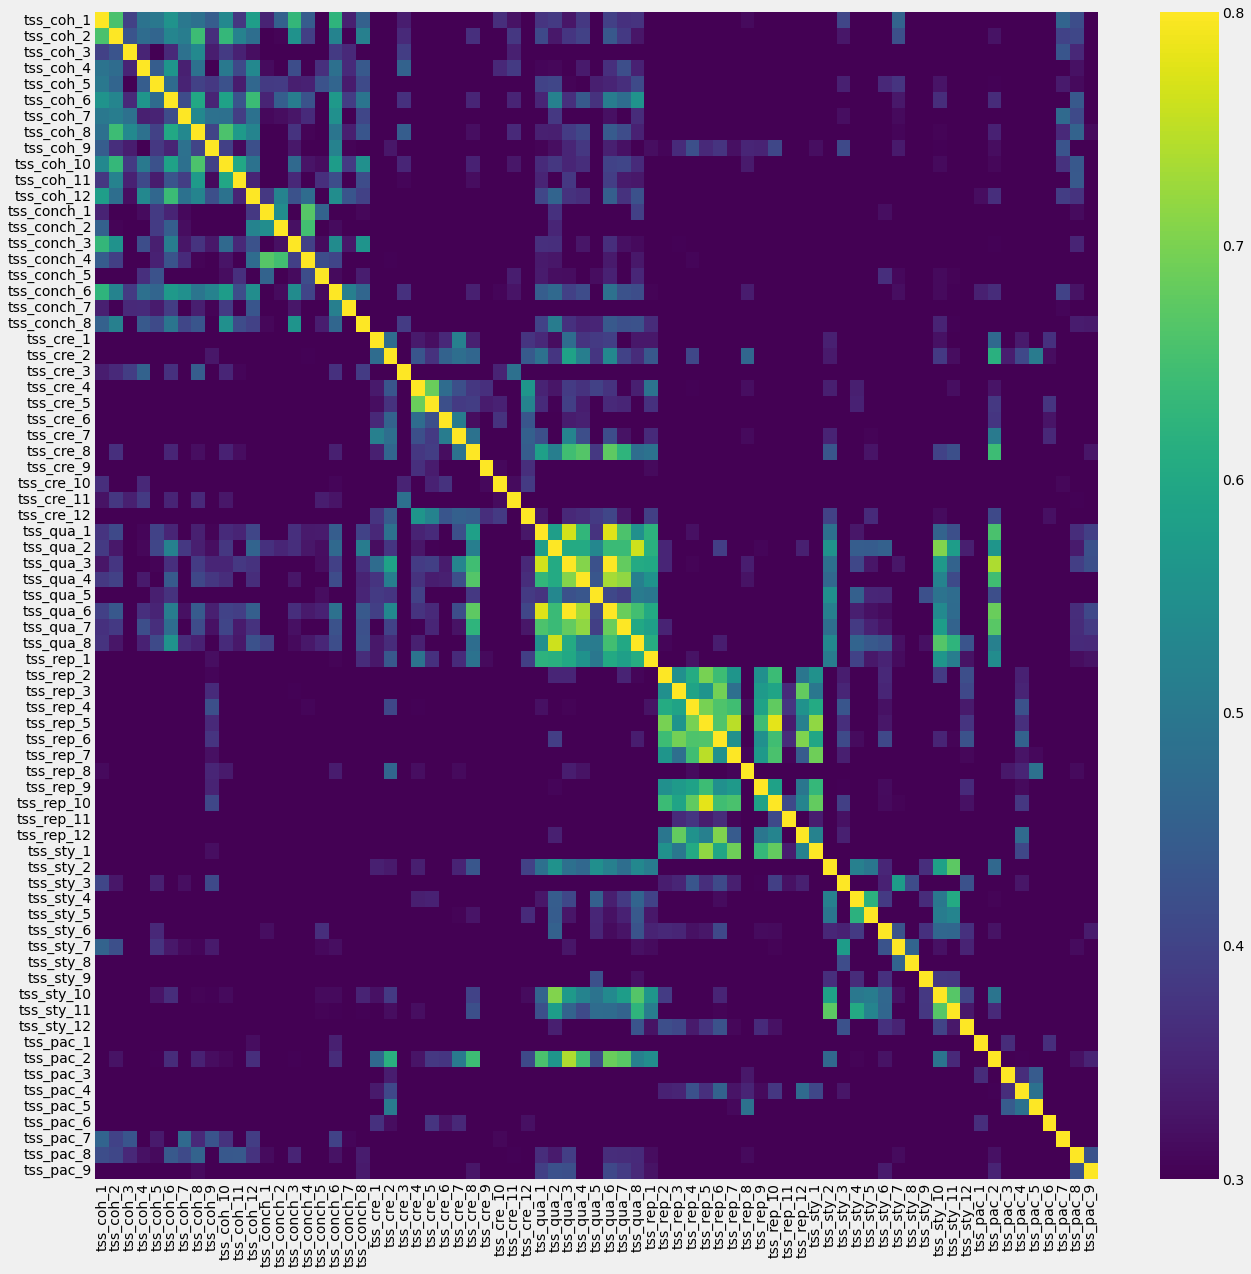

In [65]:
# Let us look at a heatmap (absolute values of correlations)
fig, ax = plt.subplots(figsize=(20, 20))

ax = sns.heatmap(abs(items_corr),
                 xticklabels=items_corr.columns.values,
                 yticklabels=items_corr.columns.values,
                 ax=ax, cmap="viridis", vmin=0.3, vmax=0.8)

# most item clusters are just surprising orthogonal (which is actually nice)

In [66]:
# Inspect suspicious items with low correlations here
susp_items = [
    "tss_cre_9", "tss_cre_10"
    "tss_rep_8",
    "tss_sty_8", "tss_sty_9"
    "tss_pac_1", "tss_pac_3", "tss_pac_5", "tss_pac_6"
]

for index, row in items_corr.iterrows():
    if index in susp_items:
        print("{}: {}".format(index, items_descr[index]))
        print("Correlations >= .3:")
        if row[(row >= .3) & (row.index != index)].empty:
            print("NONE - ALL correlations are < .3!")
        else:
            print(row[(row > .3) & (row.index != index)].to_string())
        print("")

tss_cre_9: The setting of the story was original.
Correlations >= .3:
tss_cre_4     0.366645
tss_cre_5     0.338780
tss_cre_10    0.309996
tss_cre_12    0.364948
tss_rep_1     0.312869

tss_sty_8: The writing style was too complicated to be understood easily.
Correlations >= .3:
tss_sty_3    0.41377

tss_pac_3: It took a long time for things to happen in the story.
Correlations >= .3:
tss_cre_2    0.340185
tss_rep_8    0.332453
tss_pac_4    0.363124
tss_pac_5    0.440753

tss_pac_5: Nothing seemed to be happening in the story.
Correlations >= .3:
tss_cre_2    0.505797
tss_rep_7    0.309941
tss_rep_8    0.483983
tss_pac_3    0.440753
tss_pac_4    0.486108

tss_pac_6: There was plenty of action in the story.
Correlations >= .3:
tss_cre_1     0.369002
tss_cre_5     0.376025
tss_cre_6     0.326536
tss_cre_7     0.355461
tss_cre_12    0.320081
tss_pac_1     0.365212



In [67]:
# Consider excluding variables with lots correlations < .3
items_analysis_li = copy.deepcopy(item_labels_li)

excluded_items_li = [
    "tss_sty_8"
]

for item in excluded_items_li:
    items_analysis_li.remove(item)

In [68]:
# Check for multicollinearity
def reduce_multicoll(df, vars_li, vars_descr=[], print_details=True):
    reduced_vars = copy.deepcopy(vars_li)
    print("Beginning check for multicollinearity")
    vars_corr = df[reduced_vars].corr()
    det = np.linalg.det(vars_corr)
    print("\nDeterminant of initial correlation matrix: {}\n".format(det))

    if det > .00001:
        print("Determinant is > .00001. No issues with multicollinearity detected.")
        return(reduced_vars)

    print("Starting to remove redundant variables by acessing mutlicollinearity with VIF...\n")
    count_missing = len(df) - len(df.dropna(subset=vars_li))
    if count_missing > 0:
        print("This requries dropping missing values.",
              "The following procedure will ignore {} cases with missing values".format(count_missing))
    while det <= .00001:
        # could implement pairwise dropping of missing here at some point
        # but until you have a case with lots of missing data, this will work fine
        x_df = df.dropna(subset=vars_li)[reduced_vars]
        vifs = [vif(x_df.values, i)
                for i in range(len(x_df.columns))]
        vif_data = pd.Series(vifs, index=x_df.columns)
        vif_max = (vif_data.idxmax(), vif_data.max())

        if print_details:
            print("Excluded item {}. VIF: {:.2f}".format(
                vif_max[0], vif_max[1]))

            if len(vars_descr) > 0:
                print("('{}')".format(vars_descr[vif_max[0]]))
            print("")

        reduced_vars.remove(vif_max[0])

        vars_corr = df[reduced_vars].corr()
        det = np.linalg.det(vars_corr)

    print("Done! Determinant is now: {:.6f}".format(det))
    count_removed = len(vars_li) - len(reduced_vars)
    print("I have excluded {} redunant items with {} items remaining".format(
        count_removed, len(reduced_vars)))

    return(reduced_vars)

In [69]:
items_analysis_li = reduce_multicoll(
    tss_df, items_analysis_li, vars_descr=items_descr, print_details=True)

Beginning check for multicollinearity

Determinant of initial correlation matrix: 1.475134825403836e-26

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item tss_qua_3. VIF: 49.65
('The story was fun to read.')

Excluded item tss_coh_12. VIF: 46.88
('The story lacked logic.')

Excluded item tss_coh_1. VIF: 40.83
('I had a hard time making sense of what was going on in the story.')

Excluded item tss_cre_5. VIF: 36.85
('The story was imaginative.')

Excluded item tss_cre_2. VIF: 34.35
('The story was boring.')

Excluded item tss_qua_6. VIF: 33.99
('I liked this story.')

Excluded item tss_rep_12. VIF: 29.76
('Particular words were used too often in the story.')

Excluded item tss_rep_4. VIF: 29.71
('The story was very repetitive.')

Excluded item tss_rep_5. VIF: 29.07
('In the story, the same things happened again and again.')

Excluded item tss_conch_1. VIF: 28.65
('Descriptions of characters in the story were consistent.')

Excluded item tss_

In [70]:
# Check Sampling Adequacy (KMO)
# (if SVD does not converge, dropna for participants with too many missing items)
# (might need to experiment how many missing are still okay)

tss_df.dropna(subset=items_analysis_li, thresh=1, inplace=True)

kmo = fa.factor_analyzer.calculate_kmo(tss_df[items_analysis_li])

print("Overall KMO: {}".format(kmo[1]))

i = 0
low_item_kmo = False
for item_kmo in kmo[0]:
    if item_kmo < .6:
        low_item_kmo = True
        item_label = item_labels_li[i]
        print("Low KMO for {} ('{}'): {}".format(
            item_label, items_descr[item_label], item_kmo))
    i += 1

if low_item_kmo == False:
    print("All item KMOs are >.6")

# Guidelines for KMO (Kaiser & Rice, 1974)
# Marvellous: values in the 0.90s
# Meritorious: values in the 0.80s
# Middling: values in the 0.70s
# Mediocre: values in the 0.60s
# Unacceptable: values in the 0.50s

Overall KMO: 0.8375937727959404
All item KMOs are >.6


In [71]:
# Determine number of factors
# Use Screeplot & Parallel Analysis

# Function to output results for parallel parallel analysis
def parallel_analysis(df, vars_li, k=100, facs_to_display=15, print_graph=True, print_table=True):
    # EFA with no rotation to get EVs
    efa = fa.factor_analyzer.FactorAnalyzer(rotation=None)

    # EVs for actual data
    efa.fit(df[vars_li])
    ev_pca, ev_efa = efa.get_eigenvalues()

    # Prepare random data for parallel analysis
    n, m = df[vars_li].shape
    par_efa = fa.factor_analyzer.FactorAnalyzer(rotation=None)

    # Create df to store the values
    ev_par_df = pd.DataFrame(columns=range(1, m+1))

    # Run the fit 'k' times over a random matrix
    for runNum in range(0, k):
        par_efa.fit(np.random.normal(size=(n, m)))
        cur_ev_ser = pd.Series(par_efa.get_eigenvalues()[
                               1], index=ev_par_df.columns)
        ev_par_df = ev_par_df.append(cur_ev_ser, ignore_index=True)
    # get 95th percentile for the evs
    par_95per = ev_par_df.quantile(0.95)

    if print_graph:
        # Draw graph
        plt.figure(figsize=(10, 6))

        # Line for eigenvalue 1
        plt.plot([1, facs_to_display+1], [1, 1], 'k--', alpha=0.3)
        # For the random data (parallel analysis)
        plt.plot(range(1, len(par_95per[:facs_to_display])+1),
                 par_95per[:facs_to_display], 'b', label='EVs - random', alpha=0.4)
        # Markers and line for actual EFA eigenvalues
        plt.scatter(
            range(1, len(ev_efa[:facs_to_display])+1), ev_efa[:facs_to_display])
        plt.plot(range(1, len(ev_efa[:facs_to_display])+1),
                 ev_efa[:facs_to_display], label='EVs - survey data')

        plt.title('Parallel Analysis Scree Plots', {'fontsize': 20})
        plt.xlabel('Components', {'fontsize': 15})
        plt.xticks(ticks=range(1, facs_to_display+1),
                   labels=range(1, facs_to_display+1))
        plt.ylabel('Eigenvalue', {'fontsize': 15})
        plt.legend()
        plt.show()

    if print_table:
        # Create simple table with values for 95th percentile for random data and EVs for actual data
        print("Factor eigenvalues for the 95th percentile of {} random matricesand for survey data for first {} factors:\n".
              format(k, facs_to_display))
        print("\033[1mFactor\tEV - random data 95h perc.\tEV survey data\033[0m")

        last_index = 0
        last_95per_par = 0
        last_ev_efa = 0
        found_threshold = False

        # Loop that prints previous (!) values
        # if current EV from survey data is smaller than 95th percentile from random data, we reached the threshold
        # in that case print the previous values in bold as it marks the number of factors determined by parallel analysis
        for index, cur_ev_par in par_95per[:facs_to_display].iteritems():
            cur_ev_efa = ev_efa[index-1]
            if (index > 1) & (cur_ev_par >= cur_ev_efa) & (found_threshold == False):
                found_threshold = True
                print("\033[1m{}\t{:.2f}\t\t\t\t{:.2f}\033[0m".format(
                    last_index, last_95per_par, last_ev_efa))
            elif (index > 1):
                print("{}\t{:.2f}\t\t\t\t{:.2f}".format(
                    last_index, last_95per_par, last_ev_efa))

            if index == len(par_95per[:facs_to_display]):
                print("{}\t{:.2f}\t\t\t\t{:.2f}".format(
                    index, cur_ev_par, cur_ev_efa))

            last_index = index
            last_95per_par = cur_ev_par
            last_ev_efa = cur_ev_efa

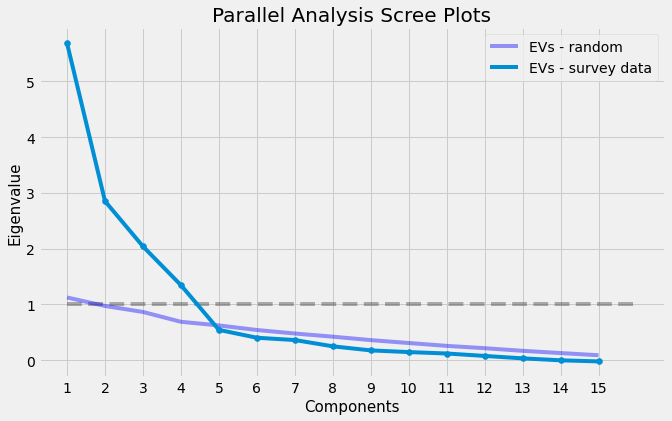

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	1.13				5.69
2	0.97				2.85
3	0.87				2.04
4	0.69				1.35
5	0.62				0.54
6	0.54				0.40
7	0.48				0.36
8	0.42				0.25
9	0.36				0.18
10	0.31				0.15
11	0.26				0.12
12	0.22				0.08
13	0.17				0.03
14	0.13				-0.00
15	0.09				-0.02


In [72]:
parallel_analysis(tss_df, items_analysis_li)

# determine factors to investigate based on screeplot and parallel analysis
# if both methods yield different results, examine both number of factors
# (decide for one based on whether you get a clean solution and on how interpretable the solution is)

In [73]:
tss_df[items_analysis_li].shape

(180, 30)

In [74]:
# Decide on rotation (orthogonal: Varimax, oblique: Oblimin)

# Run oblique rotation
efa = fa.FactorAnalyzer(n_factors=4, rotation='oblimin')
efa.fit(tss_df[items_analysis_li])
# Display factor correlation matrix
print("\nFactor Correlation Matrix (Oblique Rotation):")
print(efa.phi_)
# If matrix has clear correlations between factors, than this indicates the need for an oblique rotation
# if in doubt use oblique


Factor Correlation Matrix (Oblique Rotation):
[[ 1.          0.18517612 -0.2794209   0.05935622]
 [ 0.18517612  1.         -0.09445142 -0.16965004]
 [-0.2794209  -0.09445142  1.          0.01407293]
 [ 0.05935622 -0.16965004  0.01407293  1.        ]]


In [75]:
def iterative_efa(data, vars_analsis, n_facs=4, rotation_method="Oblimin",
                  comm_thresh=0.2, main_thresh=0.4, cross_thres=0.3, load_diff_thresh=0.2,
                  print_details=False, print_par_plot=False, print_par_table=False,
                  par_k=100, par_n_facs=15):
    efa = fa.FactorAnalyzer(n_factors=n_facs, rotation=rotation_method)

    final_solution = False

    curr_vars = copy.deepcopy(vars_analsis)

    i = 1
    while final_solution == False:
        # Fit EFA
        efa.fit(data[curr_vars])
        print("Fitted solution #{}\n".format(i))

        # print screeplot and/or table for parallel analysis if option was chosen
        # but not for first run (assuming it was already checked to select number of factors)
        if (i > 1) and print_par_plot or print_par_table:
            parallel_analysis(data, curr_vars, k=par_k, facs_to_display=par_n_facs,
                              print_graph=print_par_plot, print_table=print_par_table)

        # Check 1: Check communcalities
        print("Checking for low communalities")
        comms = pd.DataFrame(efa.get_communalities(
        ), index=tss_df[curr_vars].columns, columns=['Communality'])
        mask_low_comms = comms["Communality"] < comm_thresh

        if comms[mask_low_comms].empty:
            print("All communalities above {}\n".format(comm_thresh))
        else:
            # save bad items and remove them
            bad_items = comms[mask_low_comms].index
            print("Detected {} items with low communality. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nCommunality: {:.4f}\n".format(
                        item, items_descr[item], comms.loc[item, "Communality"]))
                curr_vars.remove(item)
            i += 1
            continue

        # Check 2: Check for low main loading
        print("Checking for low main loading")
        loadings = pd.DataFrame(efa.loadings_, index=data[curr_vars].columns)
        max_loadings = abs(loadings).max(axis=1)
        mask_low_main = max_loadings < main_thresh
        if max_loadings[mask_low_main].empty:
            print("All main loadings above {}\n".format(main_thresh))
        else:
            # save bad items and remove them
            bad_items = max_loadings[mask_low_main].index
            print("Detected {} items with low main loading. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nMain (absolute) Loading: {:.4f}\n".format(
                        item, items_descr[item], abs(loadings.loc[item]).max()))
                curr_vars.remove(item)
            i += 1
            continue

        # check 3: Check for high cross loadings
        print("Checking high cross loadings")

        # create df that stores main_load, largest crossload and difference between the two
        crossloads_df = pd.DataFrame(index=curr_vars)

        crossloads_df["main_load"] = abs(loadings).max(axis=1)
        crossloads_df["cross_load"] = abs(loadings).apply(
            lambda row: row.nlargest(2).values[-1], axis=1)
        crossloads_df["diff"] = crossloads_df["main_load"] - \
            crossloads_df["cross_load"]

        mask_high_cross = (crossloads_df["cross_load"] > cross_thres) | (
            crossloads_df["diff"] < load_diff_thresh)

        if crossloads_df[mask_high_cross].empty:
            print("All cross_loadins loadings below {}".format(cross_thres),
                  "and differences between main loading and crossloadings above {}.\n".format(load_diff_thresh))
        else:
            # save bad items and remove them
            bad_items = crossloads_df[mask_high_cross].index
            print("Detected {} items with high cross loading. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nLoadings: \n{}\n".format(
                        item, items_descr[item], loadings.loc[item]))
                curr_vars.remove(item)
            i += 1
            continue

        print("Final solution reached.")
        final_solution = True

        corrs = data[curr_vars].corr()
        det = np.linalg.det(corrs)
        print("\nDeterminant of correlation matrix: {}".format(det))
        if det > 0.00001:
            print("Determinant looks good!")
        else:
            print("Determinant is smaller than 0.00001!")
            print(
                "Consider using stricer criteria and/or removing highly correlated vars")

        kmo = fa.factor_analyzer.calculate_kmo(data[curr_vars])
        print("Overall KMO: {}".format(kmo[1]))

        i = 0
        low_item_kmo = False
        for item_kmo in kmo[0]:
            if item_kmo < .6:
                low_item_kmo = True
                item_label = curr_vars[i]
                print("Low KMO for {} ('{}'): {}".format(
                    item_label, items_descr[item_label], item_kmo))
            i += 1
        if low_item_kmo == False:
            print("All item KMOs are >.6")

# Determinant should be > .00001

    return(efa, curr_vars)

# print relevant loadings for each factor to output


def print_sorted_loadings(efa, item_lables, load_thresh=0.4, descr=[]):
    loadings = pd.DataFrame(efa.loadings_, index=item_lables)
    n_load = loadings.shape[1]

    if len(descr) > 0:
        loadings["descr"] = loadings.apply(lambda x: descr[x.name], axis=1)

    for i in range(0, n_load):
        mask_relev_loads = abs(loadings[i]) > load_thresh
        sorted_loads = loadings[mask_relev_loads].sort_values(
            i, key=abs, ascending=False)
        print("Relevant loadings for factor {}".format(i))
        if len(descr) > 0:
            print(sorted_loads[[i, "descr"]].to_string(), "\n")
        else:
            print(sorted_loads[i].to_string(), "\n")

def rev_items_and_return(df, efa, item_lables, load_thresh=0.4, min_score=1, max_score=5):

    loadings = pd.DataFrame(efa.loadings_, index=item_lables)
    n_load = loadings.shape[1]

    items_per_fact_dict = {}

    # loop through n factors
    # determine relevant items that are positive (can just be used as is)
    # and items with negative loads (need to be refersed)
    for i in range(0, n_load):
        mask_pos_loads = loadings[i] > load_thresh
        mask_neg_loads = loadings[i] < -load_thresh
        pos_items = loadings[mask_pos_loads].index.tolist()
        neg_items = loadings[mask_neg_loads].index.tolist()

        # add items with positive items directly to dict
        items_per_fact_dict[i] = pos_items

        # create reverse-coded item in df for items with negative loadings
        for item in neg_items:
            rev_item_name = item + "_rev"
            df[rev_item_name] = (df[item] - (max_score+min_score)) * -1
            items_per_fact_dict[i].append(rev_item_name)

    return items_per_fact_dict

Fitted solution #1

Checking for low communalities
Detected 1 items with low communality. Excluding them for next analysis.

Removed item tss_sty_9: The story contained a great deal of detail.
Communality: 0.1877

Fitted solution #2



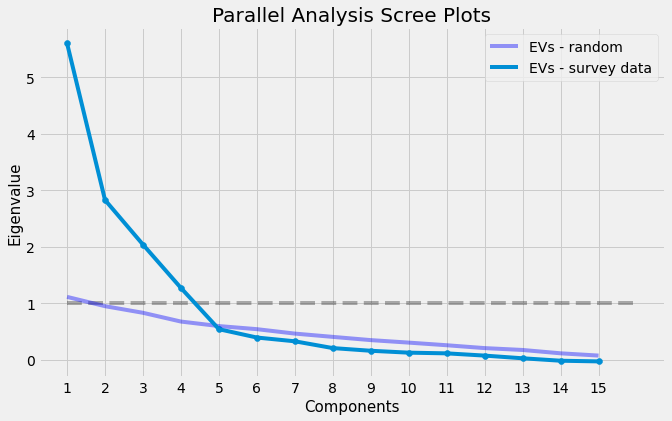

Checking for low communalities
Detected 1 items with low communality. Excluding them for next analysis.

Removed item tss_cre_9: The setting of the story was original.
Communality: 0.1984

Fitted solution #3



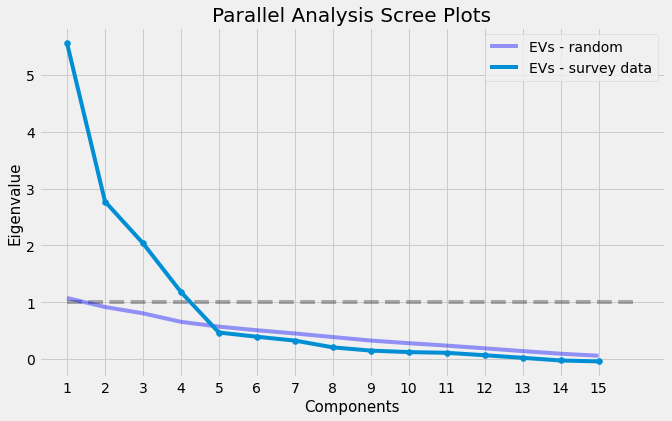

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 1 items with low main loading. Excluding them for next analysis.

Removed item tss_pac_9: There's nothing superfluous or unnecessary in this story.
Main (absolute) Loading: 0.3943

Fitted solution #4



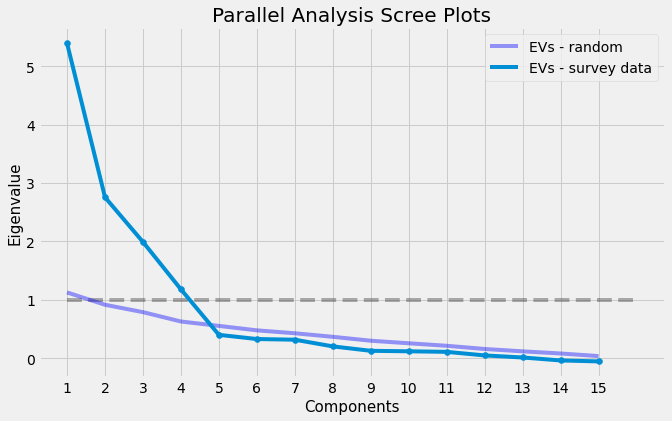

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 7 items with high cross loading. Excluding them for next analysis.

Removed item tss_coh_9: The story felt like a series of disconnected sentences.
Loadings: 
0   -0.501859
1    0.460229
2    0.042190
3    0.115560
Name: tss_coh_9, dtype: float64

Removed item tss_cre_7: There were interesting twists and turns in the story.
Loadings: 
0    0.094222
1    0.073028
2    0.617305
3   -0.327138
Name: tss_cre_7, dtype: float64

Removed item tss_qua_7: I would like to read more stories like this one.
Loadings: 
0    0.482463
1   -0.201481
2    0.500889
3    0.056592
Name: tss_qua_7, dtype: float64

Removed item tss_rep_8: The plot had no development.
Loadings: 
0   -0.330085
1    0.231459
2   -0.222413
3    0.485505
Name: tss_rep_8, dtype: float64

Removed item tss_sty_3: The story had sentences that were unreadable
Loadings: 
0   -0.3243

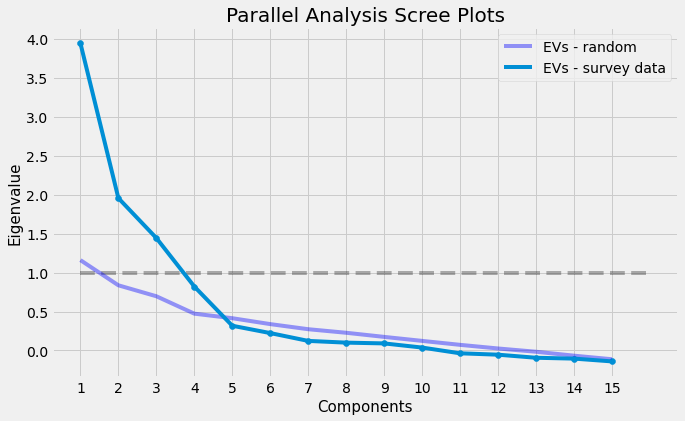

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 2 items with high cross loading. Excluding them for next analysis.

Removed item tss_cre_3: The plot development in the story was predictable.
Loadings: 
0    0.470727
1    0.057943
2    0.292780
3   -0.176159
Name: tss_cre_3, dtype: float64

Removed item tss_pac_7: Many things seemed to be happening at once in the story.
Loadings: 
0   -0.482421
1    0.218103
2   -0.080532
3    0.311877
Name: tss_pac_7, dtype: float64

Fitted solution #6



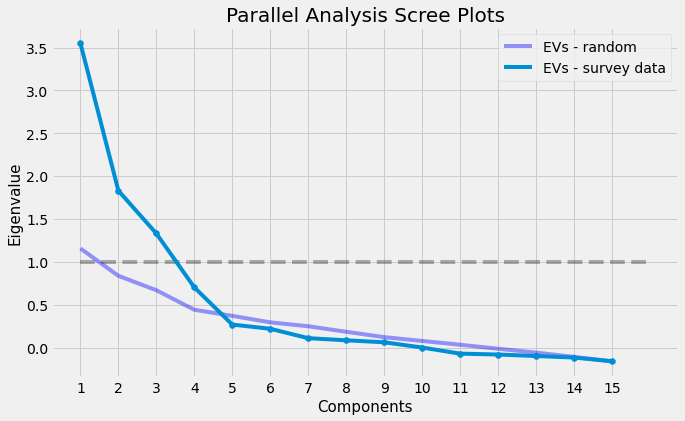

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 1 items with high cross loading. Excluding them for next analysis.

Removed item tss_conch_7: How characters in the story acted seemed implausible.
Loadings: 
0   -0.426906
1    0.175592
2   -0.238665
3    0.059867
Name: tss_conch_7, dtype: float64

Fitted solution #7



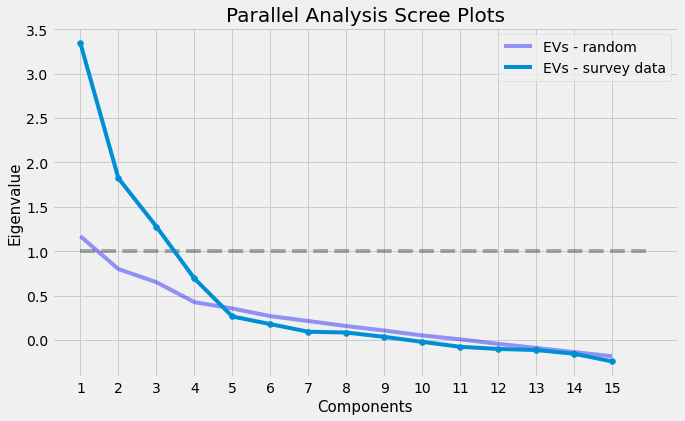

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3 and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.007490751846154167
Determinant looks good!
Overall KMO: 0.7661767028578922
Low KMO for tss_cre_6 ('It was surprising how things turned out in the story.'): 0.5900557867608106


In [76]:
four_facs = iterative_efa(tss_df, items_analysis_li, n_facs=4, rotation_method="Varimax", print_details=True,
                          print_par_plot=True)

In [77]:
efa_4 = four_facs[0]
items_4 = four_facs[1]

print_sorted_loadings(efa_4, items_4, load_thresh=0.32, descr=items_descr)

Relevant loadings for factor 0
                    0                                                                     descr
tss_coh_2   -0.787150                    I had a hard time recognizing the thread of the story.
tss_coh_6    0.724630                                     The story felt like a coherent story.
tss_conch_8  0.640512  It was easy to understand the motivation of the characters in the story.
tss_coh_11   0.638439                                              The story had a clear theme.
tss_coh_5    0.577167                         This story’s events occurred in a plausible order
tss_pac_8    0.566073                      All elements of the story were relevant to the plot.
tss_conch_4 -0.465200                   The way the characters were described was inconsistent. 

Relevant loadings for factor 1
                   1                                                                             descr
tss_rep_9   0.774171  One character did something he or she had a

In [78]:
items_per_fac_4 = rev_items_and_return(tss_df, efa_4, items_4)

for factor_n in items_per_fac_4:
    print("Internal consistency for factor {}:".format(factor_n))

    items = items_per_fac_4[factor_n]

    if len(items) > 2:
        cron_alpha = pg.cronbach_alpha(data=tss_df[items], ci=.95)
        print("Cronbachs alpha = {:.4f}, 95% CI = [{:.2f}, {:.2f}]".format(
            cron_alpha[0], cron_alpha[1][0], cron_alpha[1][1]))

        # loop over items for current factor
        # compute cronbach's alpha by excluding one item at a time
        print("\nCronbach's alpha when excluding variable...")
        for cur_item in items:
            # create list with all items except current item
            items_wo_cur_item = copy.deepcopy(items)
            items_wo_cur_item.remove(cur_item)

            cur_cron_alpha = pg.cronbach_alpha(
                data=tss_df[items_wo_cur_item], ci=.95)[0]

            # bold entry if excluding item leads to improvement
            bold_or_not = "\033[1m" if cur_cron_alpha > cron_alpha[0] else "\033[0m"
            print("{}{}: {:.4f}\033[0m".format
                  (bold_or_not, cur_item, cur_cron_alpha))

        print("\n")

# consider dropping items at this point
# Consider dropping alpha if it would noticeable improve internal consistency
# Drop items if you have > 6 items and dropping rest would not noticeable decrease internal consistency
# (also take loadings into account here)
# Be wary of dropping items if it would bring you down to 2 items...

Internal consistency for factor 0:
Cronbachs alpha = 0.8262, 95% CI = [0.78, 0.86]

Cronbach's alpha when excluding variable...
tss_coh_5: 0.8063
tss_coh_6: 0.7858
tss_coh_11: 0.8031
tss_conch_8: 0.8007
tss_pac_8: 0.8144
tss_coh_2_rev: 0.7831
tss_conch_4_rev: 0.8228


Internal consistency for factor 1:
Cronbachs alpha = 0.7673, 95% CI = [0.71, 0.82]

Cronbach's alpha when excluding variable...
tss_rep_3: 0.6900
tss_rep_9: 0.6667
tss_rep_11: 0.7974
tss_sty_1: 0.6760


Internal consistency for factor 2:
Cronbachs alpha = 0.6059, 95% CI = [0.49, 0.70]

Cronbach's alpha when excluding variable...
tss_pac_3: 0.3430
tss_pac_5: 0.5309
tss_pac_1_rev: 0.6118


Internal consistency for factor 3:
Cronbachs alpha = 0.5972, 95% CI = [0.48, 0.69]

Cronbach's alpha when excluding variable...
tss_cre_6: 0.5281
tss_cre_12: 0.3495
tss_sty_5: 0.5988




In [79]:
items_4_2 = copy.deepcopy(items_4)
items_4_2.remove("tss_conch_4")
items_4_2.remove("tss_rep_11")
items_4_2.extend(["tss_cre_1","tss_cre_2","tss_cre_4","tss_cre_5","tss_cre_8","tss_cre_10","tss_cre_11"])
items_4_2.extend(["tss_pac_2","tss_pac_4"])

In [80]:
items_4_2 = reduce_multicoll(
    tss_df, items_4_2, vars_descr=items_descr, print_details=True)

Beginning check for multicollinearity

Determinant of initial correlation matrix: 4.661459150496802e-05

Determinant is > .00001. No issues with multicollinearity detected.


Fitted solution #1

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 6 items with high cross loading. Excluding them for next analysis.

Removed item tss_cre_1: The story felt dynamic.
Loadings: 
0    0.465566
1    0.104136
2   -0.123689
3   -0.323915
Name: tss_cre_1, dtype: float64

Removed item tss_cre_2: The story was boring.
Loadings: 
0   -0.519961
1   -0.242040
2    0.183816
3    0.510229
Name: tss_cre_2, dtype: float64

Removed item tss_cre_8: I was intrigued by the plot.
Loadings: 
0    0.525416
1    0.407479
2   -0.042030
3   -0.160782
Name: tss_cre_8, dtype: float64

Removed item tss_cre_10: The story was unconventional.
Loadings: 
0    0.481281
1   -0.392238
2    0.144005
3   -0.010788
Name: tss_cre_10, dtype: float64

Removed item tss_pac_2: The story was exciting to read.
Loadings: 
0    0.520031
1    0.437026
2   -0.088674
3   -0.297756
Name: tss_pac_2, dtype: float

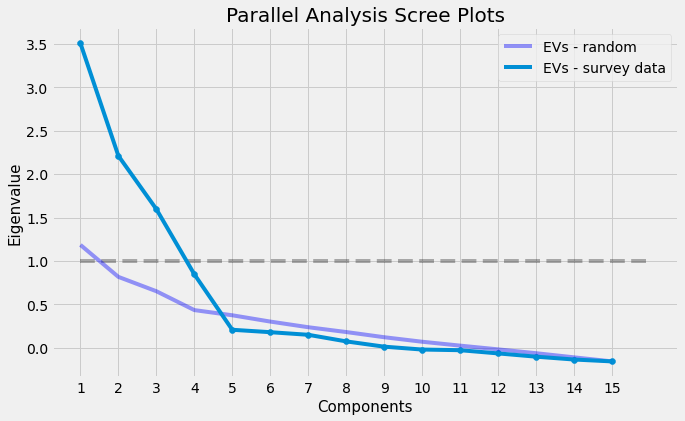

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3 and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.0022778057921163434
Determinant looks good!
Overall KMO: 0.7721116619665298
Low KMO for tss_pac_1 ('The story moved at a fast pace.'): 0.599586485635172
Low KMO for tss_pac_3 ('It took a long time for things to happen in the story.'): 0.5837388992734088


In [81]:
four_facs_2 = iterative_efa(tss_df, items_4_2, n_facs=4, rotation_method="Varimax", print_details=True,
                          print_par_plot=True)

In [82]:
efa_4_2 = four_facs_2[0]
items_4_2 = four_facs_2[1]

print_sorted_loadings(efa_4_2, items_4_2, load_thresh=0.4, descr=items_descr)

Relevant loadings for factor 0
                    0                                                                     descr
tss_coh_2   -0.783929                    I had a hard time recognizing the thread of the story.
tss_coh_6    0.709579                                     The story felt like a coherent story.
tss_coh_11   0.638664                                              The story had a clear theme.
tss_conch_8  0.631478  It was easy to understand the motivation of the characters in the story.
tss_pac_8    0.578599                      All elements of the story were relevant to the plot.
tss_coh_5    0.561724                         This story’s events occurred in a plausible order
tss_cre_11   0.486515                              The plot was typical for this kind of story. 

Relevant loadings for factor 1
                   1                                                  descr
tss_cre_4   0.796802                                The story was creative.
tss_cre_5   0.77

In [83]:
items_per_fac_4_2 = rev_items_and_return(tss_df, efa_4_2, items_4_2)

for factor_n in items_per_fac_4_2:
    print("Internal consistency for factor {}:".format(factor_n))

    items = items_per_fac_4_2[factor_n]

    if len(items) > 2:
        cron_alpha = pg.cronbach_alpha(data=tss_df[items], ci=.95)
        print("Cronbachs alpha = {:.4f}, 95% CI = [{:.2f}, {:.2f}]".format(
            cron_alpha[0], cron_alpha[1][0], cron_alpha[1][1]))

        # loop over items for current factor
        # compute cronbach's alpha by excluding one item at a time
        print("\nCronbach's alpha when excluding variable...")
        for cur_item in items:
            # create list with all items except current item
            items_wo_cur_item = copy.deepcopy(items)
            items_wo_cur_item.remove(cur_item)

            cur_cron_alpha = pg.cronbach_alpha(
                data=tss_df[items_wo_cur_item], ci=.95)[0]

            # bold entry if excluding item leads to improvement
            bold_or_not = "\033[1m" if cur_cron_alpha > cron_alpha[0] else "\033[0m"
            print("{}{}: {:.4f}\033[0m".format
                  (bold_or_not, cur_item, cur_cron_alpha))

        print("\n")

Internal consistency for factor 0:
Cronbachs alpha = 0.8246, 95% CI = [0.78, 0.86]

Cronbach's alpha when excluding variable...
tss_coh_5: 0.8071
tss_coh_6: 0.7862
tss_coh_11: 0.7998
tss_conch_8: 0.7987
tss_pac_8: 0.8079
tss_cre_11: 0.8228
tss_coh_2_rev: 0.7802


Internal consistency for factor 1:
Cronbachs alpha = 0.7845, 95% CI = [0.73, 0.83]

Cronbach's alpha when excluding variable...
tss_cre_6: 0.7664
tss_cre_12: 0.7214
tss_sty_5: 0.8064
tss_cre_4: 0.7018
tss_cre_5: 0.7136


Internal consistency for factor 2:
Cronbachs alpha = 0.7974, 95% CI = [0.74, 0.84]

Cronbach's alpha when excluding variable...
tss_rep_3: 0.7754
tss_rep_9: 0.6644
tss_sty_1: 0.7264


Internal consistency for factor 3:
Cronbachs alpha = 0.6059, 95% CI = [0.49, 0.70]

Cronbach's alpha when excluding variable...
tss_pac_3: 0.3430
tss_pac_5: 0.5309
tss_pac_1_rev: 0.6118




In [84]:
items_per_fac_4_2[1].remove("tss_sty_5")
items_per_fac_4_2

{0: ['tss_coh_5',
  'tss_coh_6',
  'tss_coh_11',
  'tss_conch_8',
  'tss_pac_8',
  'tss_cre_11',
  'tss_coh_2_rev'],
 1: ['tss_cre_6', 'tss_cre_12', 'tss_cre_4', 'tss_cre_5'],
 2: ['tss_rep_3', 'tss_rep_9', 'tss_sty_1'],
 3: ['tss_pac_3', 'tss_pac_5', 'tss_pac_1_rev']}

In [85]:
# compute scale means but only if at least 66% of questions are answered
mask_suff_data_coh = tss_df[items_per_fac_4_2[0]].isna().sum(axis=1) <= 3
mask_suff_data_cre = tss_df[items_per_fac_4_2[1]].isna().sum(axis=1) <= 2
mask_suff_data_rep = tss_df[items_per_fac_4_2[2]].isna().sum(axis=1) <= 1
mask_suff_data_pac = tss_df[items_per_fac_4_2[3]].isna().sum(axis=1) <= 1
tss_df["tss_coh"] = tss_df[mask_suff_data_coh][items_per_fac_4_2[0]].mean(axis=1)
tss_df["tss_cre"] = tss_df[mask_suff_data_cre][items_per_fac_4_2[1]].mean(
    axis=1)
tss_df["tss_rep"] = tss_df[mask_suff_data_rep][items_per_fac_4_2[2]].mean(axis=1)
tss_df["tss_pac"] = tss_df[mask_suff_data_pac][items_per_fac_4_2[3]].mean(axis=1)

# Some scales might make more sense fully reversed
tss_df["tss_pac"] = (tss_df["tss_pac"]-6)*-1
tss_df["tss_avoid_rep"] = (tss_df["tss_rep"]-6)*-1

In [86]:
# if you actually have missing data, double check if this worked as intended
tss_df[~mask_suff_data_cre]

,response_id,story_id,prompt_label,preset_label,sample,tss_coh_1,tss_coh_2,tss_coh_3,tss_coh_4,tss_coh_5,...,pass_qual_1,pass_qual_2,tss_coh_2_rev,tss_conch_4_rev,tss_pac_1_rev,tss_coh,tss_cre,tss_rep,tss_pac,tss_avoid_rep


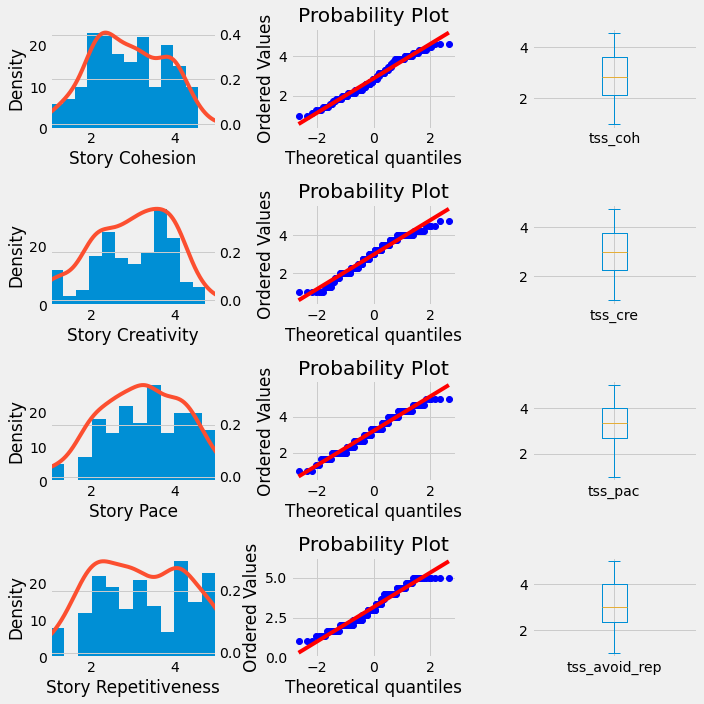

In [87]:
# Check scale distributions
fig, axes = plt.subplots(4, 3, figsize=(10, 10))

# Histograms with KDE
ax1 = tss_df["tss_coh"].plot.hist(ax=axes[0, 0], bins=12)
ax1.set_xlabel("Story Cohesion")
ax1.set_xlim(1, 5)
tss_df["tss_coh"].plot.kde(ax=axes[0, 0], secondary_y=True)

ax2 = tss_df["tss_cre"].plot.hist(ax=axes[1, 0], bins=12)
ax2.set_xlabel("Story Creativity")
ax2.set_xlim(1, 5)
tss_df["tss_cre"].plot.kde(ax=axes[1, 0], secondary_y=True)

ax3 = tss_df["tss_pac"].plot.hist(ax=axes[2, 0], bins=12)
tss_df["tss_pac"].plot.kde(ax=axes[2, 0], secondary_y=True)
ax3.set_xlabel("Story Pace")
ax3.set_xlim(1, 5)

ax4 = tss_df["tss_avoid_rep"].plot.hist(ax=axes[3, 0], bins=12)
tss_df["tss_avoid_rep"].plot.kde(ax=axes[3, 0], secondary_y=True)
ax4.set_xlabel("Story Repetitiveness")
ax4.set_xlim(1, 5)

# Q-Q Plots
stats.probplot(tss_df["tss_coh"], dist="norm", plot=axes[0, 1])
stats.probplot(tss_df["tss_cre"], dist="norm", plot=axes[1, 1])
stats.probplot(tss_df["tss_pac"], dist="norm", plot=axes[2, 1])
stats.probplot(tss_df["tss_avoid_rep"], dist="norm", plot=axes[3, 1])

# Boxplots
tss_df["tss_coh"].plot.box(ax=axes[0, 2])
tss_df["tss_cre"].plot.box(ax=axes[1, 2])
tss_df["tss_pac"].plot.box(ax=axes[2, 2])
tss_df["tss_avoid_rep"].plot.box(ax=axes[3, 2])

fig.tight_layout()
plt.show()

In [88]:
tss_df[["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac"]].corr()

,tss_coh,tss_cre,tss_avoid_rep,tss_pac
tss_coh,1.000000,0.155892,0.149521,-0.078996
tss_cre,0.155892,1.000000,0.147638,0.226101
tss_avoid_rep,0.149521,0.147638,1.000000,0.090581
tss_pac,-0.078996,0.226101,0.090581,1.000000


<Figure size 720x720 with 0 Axes>

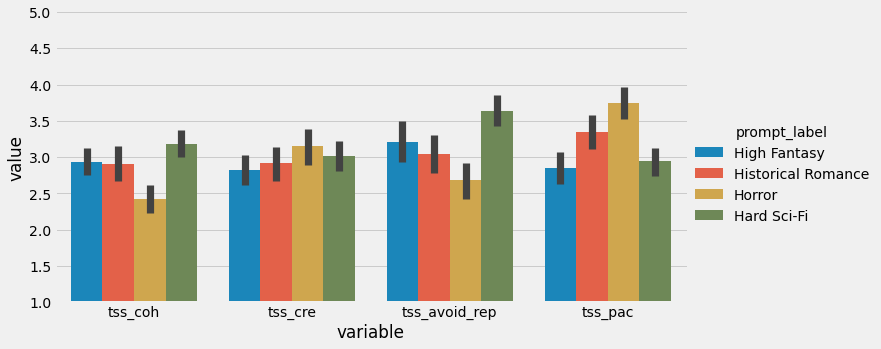

In [89]:
plt.figure(figsize=(10, 10))

tidy = tss_df[["response_id", "prompt_label", "tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac"]
              ].melt(id_vars=['response_id', "prompt_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="prompt_label",
                 ci=90, height=5, aspect=2)

plt.ylim(1, 5)

plt.show()

<Figure size 720x720 with 0 Axes>

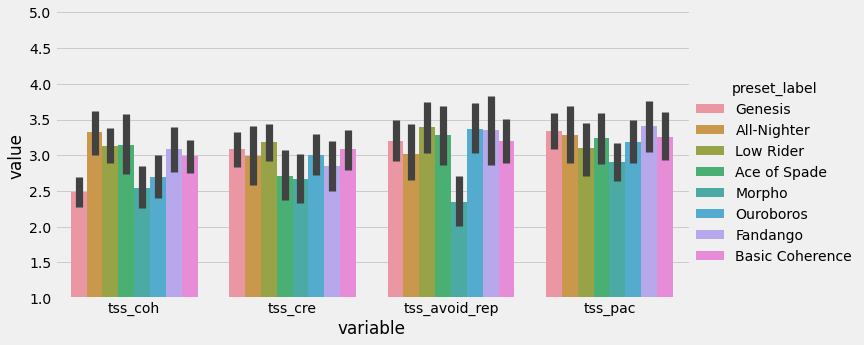

In [90]:
plt.figure(figsize=(10, 10))

tidy = tss_df[["response_id", "preset_label", "tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac"]
              ].melt(id_vars=['response_id', "preset_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="preset_label",
                 ci=90, height=5, aspect=2)

plt.ylim(1, 5)

plt.show()

<AxesSubplot:xlabel='word_count', ylabel='tss_cre'>

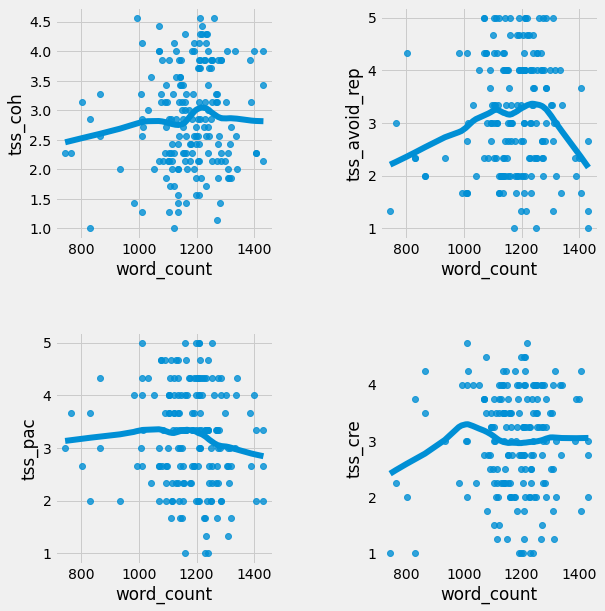

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.regplot(data=tss_df, y="tss_coh",
            x="word_count", lowess=True, ax=axes[0, 0])
sns.regplot(data=tss_df, y="tss_avoid_rep",
            x="word_count", lowess=True, ax=axes[0, 1])
sns.regplot(data=tss_df, y="tss_pac",
            x="word_count", lowess=True, ax=axes[1, 0])
sns.regplot(data=tss_df, y="tss_cre",
            x="word_count", lowess=True, ax=axes[1, 1])

In [92]:
# Setting up k-fold cross validation

kf = KFold(10, shuffle=True, random_state=42)

# Defining predictors for models
tss_df["words_cent"] = tss_df["word_count"].apply(
    lambda x: x-tss_df["word_count"].mean())  # centering

tss_df["words_cent**2"] = tss_df["words_cent"]*tss_df["words_cent"]
tss_df["words_cent**3"] = tss_df["words_cent"]**3
#tss_df["words_cent**4"] = tss_df["words_cent"]**4
#tss_df["words_cent**5"] = tss_df["words_cent"]**5

lin_model = linreg()

pred_li = [("linear", "words_cent"), ("quadratic", "words_cent**2"),
           ("cubic", "words_cent**3")]
#("quartic", "words_cent**4"),
# ("quintic", "words_cent**5")]
outcome_li = ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac"]


for outcome in outcome_li:
    y = tss_df[outcome]
    current_preds_col = []

    for pred in pred_li:
        current_preds_col.append(pred[1])
        x = tss_df.loc[:, current_preds_col]

        current_model_name = pred[0]

        cross_val = cross_validate(lin_model, x, y,
                                   scoring=["neg_mean_squared_error", "r2"], cv=kf)

        neg_mses = cross_val["test_neg_mean_squared_error"]
        r_squares = cross_val["test_r2"]
        avg_rmse = np.mean((neg_mses*-1)**0.5)
        avg_r_sq = np.mean(r_squares)
        print("Model performance for {} model predicting {}:".format(
            current_model_name, outcome))
        print("r-square: {:.4f}    RMSE: {:.4f}".format(avg_r_sq, avg_rmse))
    print("")

# word count is completly irrelevant to story ratings...
# if it stays this way I could just run a MANOVA

Model performance for linear model predicting tss_coh:
r-square: -0.0552    RMSE: 0.8558
Model performance for quadratic model predicting tss_coh:
r-square: -0.0613    RMSE: 0.8580
Model performance for cubic model predicting tss_coh:
r-square: -0.0781    RMSE: 0.8648

Model performance for linear model predicting tss_cre:
r-square: -0.0256    RMSE: 0.9210
Model performance for quadratic model predicting tss_cre:
r-square: -0.0274    RMSE: 0.9218
Model performance for cubic model predicting tss_cre:
r-square: -0.0048    RMSE: 0.9116

Model performance for linear model predicting tss_avoid_rep:
r-square: -0.0459    RMSE: 1.0883
Model performance for quadratic model predicting tss_avoid_rep:
r-square: 0.0006    RMSE: 1.0636
Model performance for cubic model predicting tss_avoid_rep:
r-square: -0.0016    RMSE: 1.0666

Model performance for linear model predicting tss_pac:
r-square: -0.0690    RMSE: 0.9565
Model performance for quadratic model predicting tss_pac:
r-square: -0.0623    RMSE:

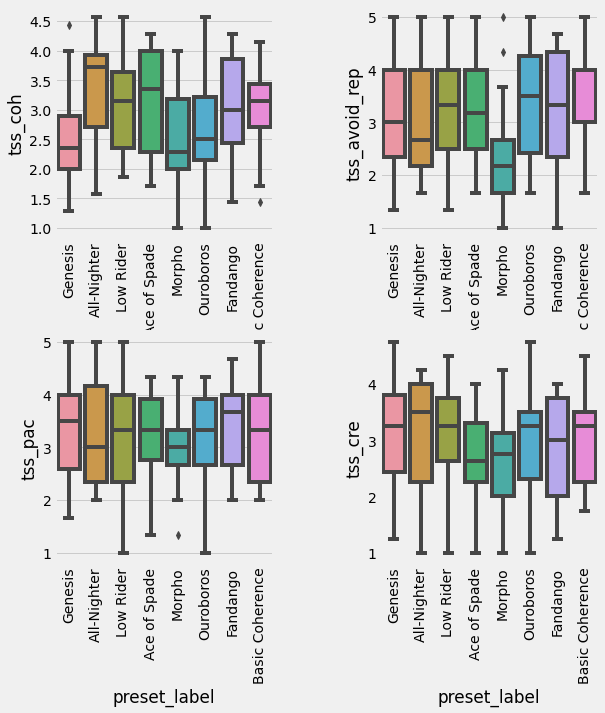

In [93]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.boxplot(x="preset_label", y="tss_coh", data=tss_df, ax=axes[0, 0])
sns.boxplot(x="preset_label", y="tss_avoid_rep", data=tss_df, ax=axes[0, 1])
sns.boxplot(x="preset_label", y="tss_pac", data=tss_df, ax=axes[1, 0])
sns.boxplot(x="preset_label", y="tss_cre", data=tss_df, ax=axes[1, 1])

for ax_1, ax_2 in axes:
    ax_1.set_xticklabels(ax_1.get_xticklabels(), rotation=90)
    ax_2.set_xticklabels(ax_2.get_xticklabels(), rotation=90)

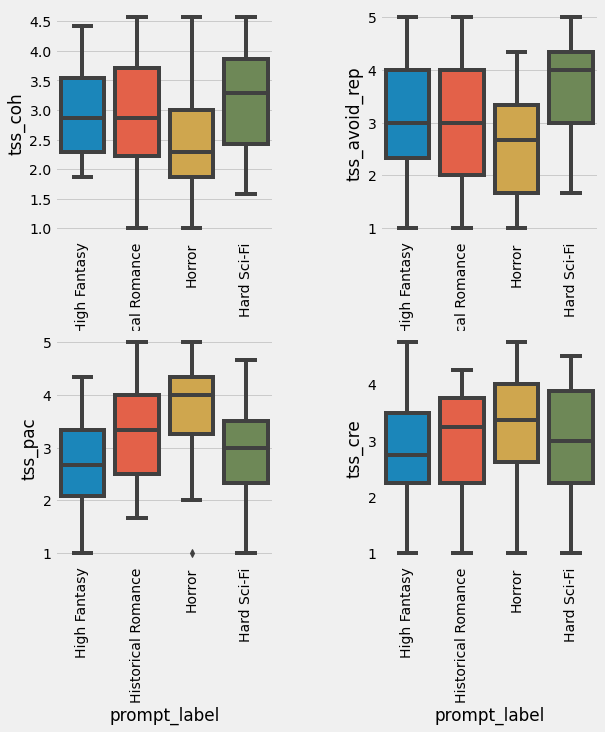

In [94]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.boxplot(x="prompt_label", y="tss_coh", data=tss_df, ax=axes[0, 0])
sns.boxplot(x="prompt_label", y="tss_avoid_rep", data=tss_df, ax=axes[0, 1])
sns.boxplot(x="prompt_label", y="tss_pac", data=tss_df, ax=axes[1, 0])
sns.boxplot(x="prompt_label", y="tss_cre", data=tss_df, ax=axes[1, 1])

for ax_1, ax_2 in axes:
    ax_1.set_xticklabels(ax_1.get_xticklabels(), rotation=90)
    ax_2.set_xticklabels(ax_2.get_xticklabels(), rotation=90)

In [95]:
def determine_outliers(df, var, distance=3, mode="print"):
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    
    iqr = q3-q1
    outlier_lower = q1 - (iqr*distance)
    outlier_upper = q3 + (iqr*distance)
    if mode == "print":
        print("25th Percentile (Q1): {:.2f}\n75th Percentile (Q3): {:.2f}\nIQR: {:.2f}".format(q1,q3,iqr))
        print("Will count cases as outlier with values less than {:.2f} or more than {:.2f}."
              .format(outlier_lower, outlier_upper))
        mask_outlier = (df[var] < outlier_lower) | (df[var] > outlier_upper)
        if df[mask_outlier].shape[0] == 0:
            print("With these criteria there are no outlier in the data")
        else:
            print("Showing outliers")
            print(df[mask_outlier][var])
    else:
        print("Mode must be 'print'")

In [96]:
print("Exterme outliers on tss_coh, Genesis preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Genesis"], "tss_coh")
print("\nExterme outliers on tss_coh, Basic Coherence preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Basic Coherence"], "tss_coh")
print("\nExterme outliers on tss_rep, Morpho preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Morpho"], "tss_avoid_rep")
print("\nExterme outliers on tss_pac, Morpho preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Morpho"], "tss_pac")
print("\nExterme outliers on tss_rep, Horror prompt")
determine_outliers(tss_df[tss_df["prompt_label"] == "Horror"], "tss_avoid_rep")

Exterme outliers on tss_coh, Genesis preset
25th Percentile (Q1): 2.00
75th Percentile (Q3): 2.89
IQR: 0.89
Will count cases as outlier with values less than -0.68 or more than 5.57.
With these criteria there are no outlier in the data

Exterme outliers on tss_coh, Basic Coherence preset
25th Percentile (Q1): 2.71
75th Percentile (Q3): 3.43
IQR: 0.71
Will count cases as outlier with values less than 0.57 or more than 5.57.
With these criteria there are no outlier in the data

Exterme outliers on tss_rep, Morpho preset
25th Percentile (Q1): 1.67
75th Percentile (Q3): 2.67
IQR: 1.00
Will count cases as outlier with values less than -1.33 or more than 5.67.
With these criteria there are no outlier in the data

Exterme outliers on tss_pac, Morpho preset
25th Percentile (Q1): 2.67
75th Percentile (Q3): 3.33
IQR: 0.67
Will count cases as outlier with values less than 0.67 or more than 5.33.
With these criteria there are no outlier in the data

Exterme outliers on tss_rep, Horror prompt
25th 

In [97]:
# Normality
def qqs_over_groups_and_vars(df, group_label, vars_li, size=(15,15)):
    groups_li = df[group_label].unique()
    fig, axes = plt.subplots(len(vars_li), len(groups_li), figsize=size)
    fig.tight_layout(pad=5.0)
    plt.grid(False)

    x = 0
    y = 0
    for group, var in itertools.product(groups_li,vars_li):
        stats.probplot(df[df[group_label]==group][var], dist="norm", plot=axes[y, x])
        axes[y, x].set_title(group + " - "+ var)
        if x < (len(groups_li)-1):
            x += 1
        else:
            x = 0
            y += 1

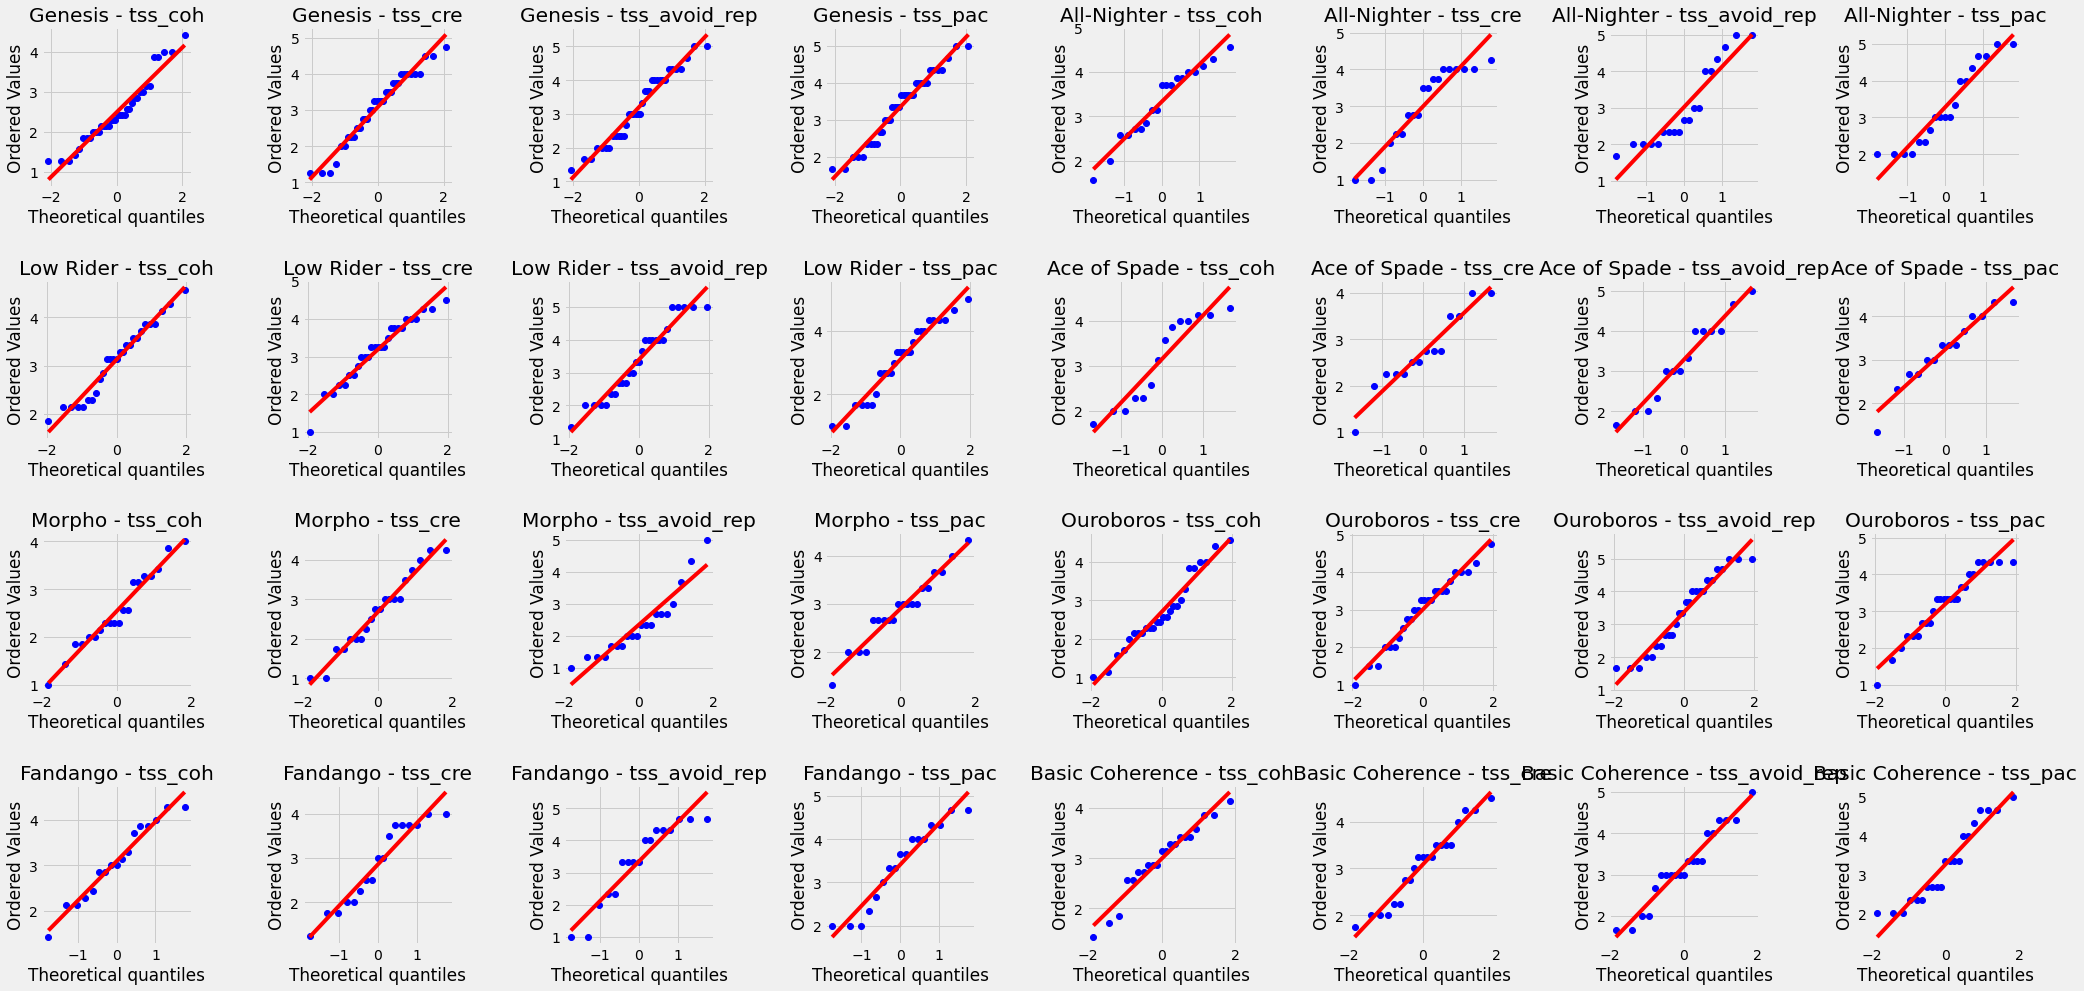

In [98]:
qqs_over_groups_and_vars(tss_df, "preset_label", outcome_li, size = (30,15))

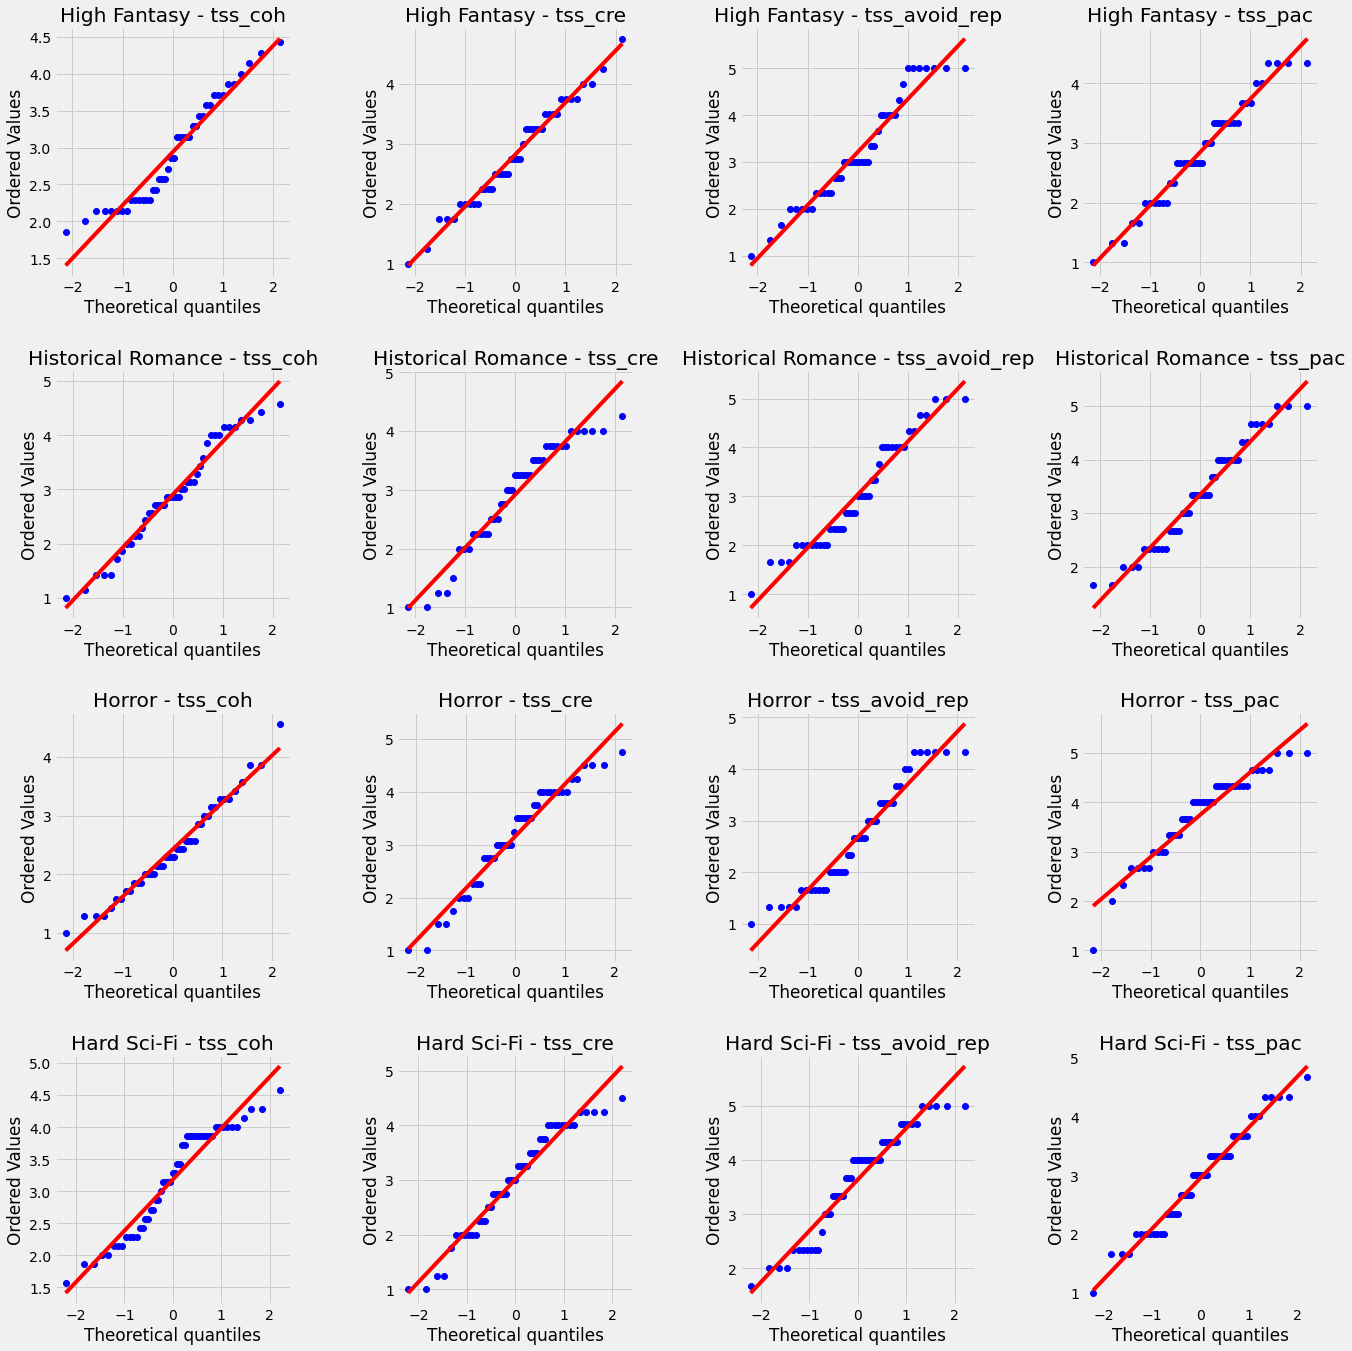

In [99]:
qqs_over_groups_and_vars(tss_df, "prompt_label", outcome_li, size = (20,20))

In [100]:
# Checking if F-test ist robust to heteroscedacity
# Taking recommended approach from Blanca et al., 2018
def anova_check_homoscedacity(y_var, group_var, df):
    var_ser = pd.Series(index=df[group_var].unique(), dtype=float)

    for group in df[group_var].unique():
        var_ser[group] = df[df[group_var] == group][y_var].var()

    min_var = (var_ser.idxmin(), var_ser.min())
    max_var = (var_ser.idxmax(), var_ser.max())
    var_ratio = max_var[1]/min_var[1]
    print("Smallest variance for {}: {:.2f}".format(min_var[0], min_var[1]))
    print("Largest variance for {}: {:.2f}".format(max_var[0], max_var[1]))
    print("Variance ratio for: {:.2f}".format(var_ratio))

    if var_ratio <= 1.5:
        print("Variance ratio is smaller or equal to 1.5, F-test will be robust.")
        return
    else:
        print("Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.")

    # Create dataframe with variance and group sizes
    var_n_df = var_ser.to_frame(name="var")
    var_n_df["n"] = df.value_counts(subset=group_var)
    # get correlation between correlation and variance
    corr_var_n = var_n_df[["var", "n"]].corr().iloc[1, 0]

    if (corr_var_n >= 0) and (corr_var_n <= 0.5):
        print("Correlation between sample size and variance (pairing) is {:.2f}. That is between 0 and .5. F-test should be robust".
              format(corr_var_n))
        return
    else:
        print("Correlation between sample size and variance (pairing) is {:.2f}. That is below 0 or over .5.".
              format(corr_var_n), "Continuing with further checks...")

    # Compute coefficient of sample size variation
    coeff_n = var_n_df["var"].std()/var_n_df["var"].mean()
    if (corr_var_n > 0.5) and (coeff_n > .33) and (var_ratio > 2):
        print("Pairing is {:.2f}, so larger than .5,".format(corr_var_n),
              ",coefficient of sample size variation is {:.2f}, larger than .33,".format(
                  coeff_n),
              "and variance ratio is {:.2f}, larger than 2.".format(var_ratio),
              "F-test is too conserative (hurting power)")
    elif (corr_var_n < 0) and (corr_var_n >= -0.5) and (coeff_n > .16) and (var_ratio > 2):
        print("Pairing is {:.2f}, so smaller than 0 and larger than or equal to -.5,".format(corr_var_n),
              ",coefficient of sample size variation is {:.2f}, larger than .16,".format(
                  coeff_n),
              "and variance ratio is {:.2f}, larger than 2.".format(var_ratio),
              "F-test is too liberal (real alpha might be as high as .1 if variance ratio is 9 or smaller).")
    elif (corr_var_n < -0.5):
        print("Pairing is {:.2f}, so smaller than -.5.".format(corr_var_n),
              "F-test is too liberal (real alpha might be as high as .2 if variance ratio is 9 or smaller).")
    else:
        print("Pairing is {}, coefficient of sample size variation is {:.2f}, variance ratio is {}."
              .format(corr_var_n, coeff_n, var_ratio),
              "This specific combination should have robust F-test, but look into the paper",
              "('Effect of variance ratio on ANOVA robustness: Might 1.5 be the limit?', Blanca et al., 2018)",
              "to be sure.")

In [101]:
for outcome in outcome_li:
    print("Checks for {}".format(outcome))
    print("Preset")
    anova_check_homoscedacity(outcome, "preset_label", tss_df)
    print("\nPrompt")
    anova_check_homoscedacity(outcome, "prompt_label", tss_df)
    print("\n")

Checks for tss_coh
Preset
Smallest variance for Basic Coherence: 0.49
Largest variance for Ace of Spade: 0.92
Variance ratio for: 1.86
Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.
Correlation between sample size and variance (pairing) is -0.25. That is below 0 or over .5. Continuing with further checks...
Pairing is -0.2484718976347213, coefficient of sample size variation is 0.22, variance ratio is 1.8570563294972746. This specific combination should have robust F-test, but look into the paper ('Effect of variance ratio on ANOVA robustness: Might 1.5 be the limit?', Blanca et al., 2018) to be sure.

Prompt
Smallest variance for High Fantasy: 0.52
Largest variance for Historical Romance: 0.92
Variance ratio for: 1.78
Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.
Correlation between sample size and variance (pairing) is -0.06. That is below 0 or over .5. Continuing with further checks...
Pairing is -0.05600

In [190]:
params_df = pd.DataFrame()

# if heteroscedacity, run with fit(cov_type='HC3') and anova_lm(anova_mod, typ=2, robust='HC3')

for outcome in outcome_li:
    print("\033[1m{}\033[0m".format(outcome))
    ols_formula = outcome + " ~ C(preset_label, Sum) + C(prompt_label, Sum) + C(sample, Treatment(0))"
    ols_formula2 = outcome + " ~ C(preset_label, Sum(0)) + C(prompt_label, Sum(0)) + C(sample, Treatment(0))"
    anova_mod = ols(
        ols_formula, tss_df).fit()
    anova_mod2 = ols(
        ols_formula2, tss_df).fit()
    print(sm.stats.anova_lm(anova_mod, typ=2))
    print(anova_mod.summary(alpha=0.1))
    
    print("\nDeviation contrasts for\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[7], anova_mod2.params[7], anova_mod2.pvalues[7]),
          "\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[10], anova_mod2.params[10], anova_mod2.pvalues[10]))
    print("\n")
    
    params_df[outcome] = anova_mod.params
    params_df[outcome + " p-value"] = anova_mod.pvalues
    params_df[outcome + " 90% CI Lower"] = anova_mod.conf_int(alpha=0.1)[0]

    params_df.loc[anova_mod2.params.index[7], outcome] = anova_mod2.params[7]
    params_df.loc[anova_mod2.params.index[7], outcome + " p-value"] = anova_mod2.pvalues[7]
    params_df.loc[anova_mod2.params.index[7], outcome + " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][7]
    
    params_df.loc[anova_mod2.params.index[10], outcome] = anova_mod2.params[10]
    params_df.loc[anova_mod2.params.index[10], outcome + " p-value"] = anova_mod2.pvalues[10]
    params_df.loc[anova_mod2.params.index[10], outcome + " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][10]

tss_coh
                             sum_sq     df         F    PR(>F)
C(preset_label, Sum)      13.250583    7.0  3.021341  0.005129
C(prompt_label, Sum)      10.415521    3.0  5.541439  0.001189
C(sample, Treatment(0))    1.179848    1.0  1.883168  0.171804
Residual                 105.255896  168.0       NaN       NaN
                            OLS Regression Results                            
Dep. Variable:                tss_coh   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     4.036
Date:                Thu, 17 Mar 2022   Prob (F-statistic):           3.03e-05
Time:                        13:06:44   Log-Likelihood:                -207.12
No. Observations:                 180   AIC:                             438.2
Df Residuals:                     168   BIC:                             476.6
Df Model:                          11        

In [191]:
params_df.index = params_df.index.str.replace(r'C\(.*[ST]\.(.*)\]', r'\1', regex=True)

# Transform 90% CI lower bound to 90% CI margin of error
for outcome in outcome_li:
    params_df[outcome + " 90% CI Lower"] = params_df[outcome] - params_df[outcome + " 90% CI Lower"]
params_df.columns = params_df.columns.str.replace("90% CI Lower", "90% CI margin", regex=False)

presets_li = list(tss_df["preset_label"].unique())
prompts_li = list(tss_df["prompt_label"].unique())

order_index = ["Intercept"]
order_index.extend(presets_li)
order_index.extend(prompts_li)

params_df = params_df.reindex(order_cols)

cols_order = []

for outcome in outcome_li:
    # adjusted ps for presets
    params_df.loc[presets_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[presets_li, outcome + " p-value"], alpha=0.1)[1]
    # adjusted ps for prompts
    params_df.loc[prompts_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[prompts_li, outcome + " p-value"], alpha=0.1)[1]
    
    cols_order.extend([outcome, outcome + " p-value", outcome + " adj_p", outcome + " 90% CI margin"])

params_df = params_df[cols_order]

In [192]:
params_df

,tss_coh,tss_coh p-value,tss_coh adj_p,tss_coh 90% CI margin,tss_cre,tss_cre p-value,tss_cre adj_p,tss_cre 90% CI margin,tss_avoid_rep,tss_avoid_rep p-value,tss_avoid_rep adj_p,tss_avoid_rep 90% CI margin,tss_pac,tss_pac p-value,tss_pac adj_p,tss_pac 90% CI margin
Intercept,2.848754,1.389195e-84,NaN,0.123659,2.831814,3.539240e-75,NaN,0.142264,3.274361,1.198848e-78,NaN,0.155771,3.324828,2.692202e-87,NaN,0.138488
Genesis,-0.398373,2.620648e-03,0.020965,0.215700,0.109077,4.682264e-01,0.749162,0.248152,0.145347,3.775527e-01,0.604084,0.271714,0.088549,5.451446e-01,0.894824,0.241566
All-Nighter,0.359363,3.574737e-02,0.119569,0.280787,0.051728,7.914465e-01,0.871906,0.323031,-0.194737,3.637986e-01,0.604084,0.353703,0.088173,6.434153e-01,0.894824,0.314459
Low Rider,0.214941,1.419438e-01,0.227110,0.240936,0.225780,1.797160e-01,0.718864,0.277184,0.287886,1.185595e-01,0.316159,0.303503,-0.120779,4.601234e-01,0.894824,0.269828
Ace of Spade,0.224357,2.522837e-01,0.336378,0.323025,-0.167041,4.582501e-01,0.749162,0.371623,-0.004008,9.870222e-01,0.987022,0.406909,0.028959,8.948244e-01,0.894824,0.361761
Morpho,-0.335495,4.483824e-02,0.119569,0.274529,-0.261114,1.733190e-01,0.718864,0.315831,-0.748782,4.474304e-04,0.003579,0.345819,-0.362038,5.312459e-02,0.424997,0.307449
Ouroboros,-0.225277,1.342422e-01,0.227110,0.247602,-0.027811,8.719064e-01,0.871906,0.284853,0.328538,8.330236e-02,0.316159,0.311900,-0.023273,8.897598e-01,0.894824,0.277294
Fandango,0.126682,4.776744e-01,0.545914,0.294431,-0.084288,6.811786e-01,0.871906,0.338728,0.109451,6.261181e-01,0.812463,0.370890,0.232204,2.457747e-01,0.894824,0.329738
Basic Coherence,0.033801,8.361240e-01,0.836124,0.269852,0.153669,4.141205e-01,0.749162,0.310451,0.076304,7.109050e-01,0.812463,0.339928,0.068205,7.094104e-01,0.894824,0.302212
High Fantasy,0.088582,4.015431e-01,0.535391,0.174213,-0.158919,1.914903e-01,0.382981,0.200423,0.101695,4.444793e-01,0.465816,0.219453,-0.349803,3.462894e-03,0.006926,0.195104


In [ ]:
labels = ["Coherence", "Creativity", "Avoiding Repitition", "Pace"]

# create dicts with a key for each preset with an empty list as value for each
marginal_means_dict = {preset: [] for preset in params_df[1:8].index}
yerr_dict = {preset: [] for preset in params_df[1:8].index}
#colors = ["tab:blue", "tab:green", "tab:red", "tab:orange"]

for preset, outcome in itertools.product(marginal_means_dict.keys(), outcome_li):
    marginal_means_dict[preset].append(params_df.loc["Intercept", outcome] + params_df.loc[preset, outcome])
    yerr_dict[preset].append(params_df.loc[preset, outcome + " 90% CI margin"])

figure = plt.figure(figsize=(10, 5))

x = np.arange(len(labels)) # label locations
width = 0.35 # width of bars

plt.bar(x-width/2, marginal_means_dict["Genesis"], width,
        yerr = yerr_dict["Genesis"], label = "Genesis", color = "tab:blue")

plt.bar(x+width/2, marginal_means_dict["Low Rider"], width,
        yerr = yerr_dict["Low Rider"], label = "Mystery Preset", color = "tab:orange")

i = 0
pos = -0.4
for outcome in outcome_li:
    grand_mean = params_df.loc["Intercept", outcome]
    ax = plt.plot([pos, pos+0.8], [grand_mean, grand_mean], '--', color = "black", alpha = 0.65)
    if i == 0:
        ax[0].set_label("Grand Mean (all Presets)")
    i += 1
    pos += 1
    
plt.ylim(1,5)
plt.ylabel("Marginal Means (Community Sample)", fontsize = 16)
plt.xticks(x, labels, fontsize = 16)

plt.legend(frameon=False, fontsize = 16, loc='upper center', ncol = 3)
leg = plt.gca().get_legend()
plt.grid(False)
#plt.title("Genesis & Low Rider")
#figure.tight_layout()
plt.show()

figure.savefig('graphs/gen_lr_1.png', bbox_inches="tight")

In [ ]:
labels = ["Coherence", "Creativity", "Avoiding Repitition", "Pace"]

# create dicts with a key for each outcome with an empty list as value for each
marginal_means_dict = {outcome: [] for outcome in outcome_li}
yerr_dict = {outcome: [] for outcome in outcome_li}
colors = ["darkblue", "darkgreen", "darkred", "darkorange"]

for preset, outcome in itertools.product(["Genesis", "Low Rider"], outcome_li):
    marginal_means_dict[outcome].append(params_df.loc["Intercept", outcome] + params_df.loc[preset, outcome])
    yerr_dict[outcome].append(params_df.loc[preset, outcome + " 90% CI margin"])

figure = plt.figure(figsize=(10, 5))

x = np.arange(len(marginal_means_dict["tss_cre"])) # label locations
width = 0.2 # width of bars

plt.bar(x-0.3, marginal_means_dict["tss_coh"], width,
        yerr = yerr_dict["tss_coh"], label = "Coherence", color = "tab:blue")

plt.bar(x-0.1, marginal_means_dict["tss_cre"], width,
         yerr = yerr_dict["tss_cre"], label = "Creativity", color = "tab:green")

plt.bar(x+0.1, marginal_means_dict["tss_avoid_rep"], width,
         yerr = yerr_dict["tss_avoid_rep"], label = "Avoiding Repetition", color = "tab:red")

plt.bar(x+0.3, marginal_means_dict["tss_pac"], width,
         yerr = yerr_dict["tss_pac"], label = "Pace", color = "tab:orange")

i = 0
pos = -0.4
for outcome in outcome_li:
    grand_mean = params_df.loc["Intercept", outcome]
    ax = plt.plot([pos, pos+width], [grand_mean, grand_mean], '--', color = "black", alpha = 0.7)
    ax = plt.plot([pos+1, pos+width+1], [grand_mean, grand_mean], '--', color = "black", alpha = 0.7)
    if i == 0:
        ax[0].set_label("Grand Mean (all Presets)")
    i += 1
    pos += width
    
plt.ylim(1,5)
plt.ylabel("Marginal Means (Community Sample)", fontsize = 16)
plt.xticks(x, ["Genesis", "Mystery Preset"], fontsize = 16)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,3,4,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           frameon=False, fontsize = 16, loc='upper center', ncol = 3, bbox_to_anchor = (0.55,1))
# plt.legend(frameon=False, bbox_to_anchor = (1,.9), fontsize = 16)
plt.grid(False)
#plt.title("Genesis & Low Rider")
#figure.tight_layout()
plt.show()

figure.savefig('graphs/gen_lr_v2.png', bbox_inches="tight")

In [ ]:
genesis_marginal_means = []
genesis_yerr = []
colors = ["tab:blue", "tab:green", "tab:red", "tab:orange"]

for outcome in outcome_li:
    genesis_marginal_means.append(params_df.loc["Intercept", outcome] + params_df.loc["Genesis", outcome])
    genesis_yerr.append(params_df.loc["Genesis", outcome + " 90% CI margin"])
    

figure = plt.figure(figsize=(10, 5))

plt.bar(["Coherence", "Creativity", "Avoiding Repitition", "Pace"], genesis_marginal_means, yerr = genesis_yerr,
       color = colors)

i = 0
pos = -0.5
for outcome in outcome_li:
    grand_mean = params_df.loc["Intercept", outcome]
    ax = plt.plot([pos, pos+1], [grand_mean, grand_mean], '--', color = colors[i])
    if i == 0:
        ax[0].set_label("Grand Mean (all Presets)")
    i += 1
    pos += 1
    
plt.ylim(1,5)
plt.ylabel("Marginal Means (Community Sample)")

plt.legend(frameon=False)
leg = plt.gca().get_legend()
leg.legendHandles[0].set_color('black')
plt.grid(False)
plt.title("Genesis Preset")
plt.show()
figure.savefig('graphs/genesis.png', bbox_inches="tight")

In [ ]:
tss_df[["tss_coh", "tss_avoid_rep", "tss_pac", "tss_cre",
        "tss_qua_1", "tss_qua_2", "tss_qua_3", "tss_qua_5", "tss_qua_6", "tss_qua_7", "tss_qua_8"]].corr(method="kendall")

In [ ]:
items_descr[["tss_cre_4","tss_qua_1", "tss_qua_2", "tss_qua_3", "tss_qua_5", "tss_qua_6", "tss_qua_7", "tss_qua_8"]]

In [ ]:
tss_df["preset_label"].value_counts()

In [ ]:
qual = tss_df.groupby('preset_label').mean()[["tss_qua_2", "tss_qua_1", "tss_qua_3"]].sort_values("tss_qua_2")

figure = plt.figure(figsize=(10, 5))
plt.bar(qual.index, qual["tss_qua_2"])
plt.xticks(rotation=45)